In [1]:
import numpy as np
from bart_playground.params import Tree, Parameters
from bart_playground.priors import ComprehensivePrior
from bart_playground.moves import Move

In [2]:
class DummyMove(Move):
    def is_feasible(self): return True
    def try_propose(self, proposed, generator): return True

In [3]:
def calculate_sse_for_node(leaf_ids, node_id, data_y):
    """
    Calculate the sum of squared errors for a single node.
    """
    node_mask = leaf_ids == node_id
    if not np.any(node_mask):
        return 0.0
    filtered_y = data_y[node_mask]
    mean_y = np.mean(filtered_y)
    sse = np.sum((filtered_y - mean_y) ** 2)
    return sse

In [4]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X = X.values.astype(float)
y = np.array(y).reshape(-1)

print(f"Dataset shape: X={X.shape}, y={y.shape}")

Dataset shape: X=(20640, 8), y=(20640,)


In [5]:
from bart_playground.util import DefaultPreprocessor

# Use DefaultPreprocessor to generate possible thresholds
preprocessor = DefaultPreprocessor(max_bins=20)  # Adjust max_bins as needed
preprocessor.fit(X, y)
possible_thresholds = preprocessor.thresholds

In [6]:
# Initialize tree with initial split
tree = Tree.new(dataX=X)
tree.split_leaf(node_id=0, var=0, threshold=X[:, 0].mean())

# Prepare Parameters and Priors
global_params = {"eps_sigma2": np.array([0.1], dtype=np.float32)}
params = Parameters([tree], global_params)
prior = ComprehensivePrior(n_trees=1)
likelihood = prior.likelihood
tree_prior = prior.tree_prior

move = DummyMove(params, trees_changed=np.array([0]))
move.tree_prior = tree_prior

residuals = y - params.evaluate(all_except=move.trees_changed)

In [7]:
# Generate ALL possible split candidates
all_candidates = [
    (node_id, var, threshold)
    for node_id in tree.leaves
    for var in range(X.shape[1])
    for threshold in possible_thresholds[var]
]

np.random.shuffle(all_candidates)

# Generate 10 split candidates
candidates = []
while len(candidates) < 10:
    node_id, var, threshold = all_candidates.pop()

    tree_copy = tree.copy()
    if tree_copy.split_leaf(node_id=node_id, var=var, threshold=threshold):
        candidates.append({
            'node_id': node_id,
            'var': var,
            'threshold': threshold
        })

print(f"\nGenerated {len(candidates)} split candidates:")
for i, cand in enumerate(candidates):
    print(f"Candidate {i+1}: split node {cand['node_id']} on var {cand['var']} at {cand['threshold']:.3f}")



Generated 10 split candidates:
Candidate 1: split node 2 on var 2 at 5.079
Candidate 2: split node 2 on var 5 at 2.076
Candidate 3: split node 2 on var 5 at 2.339
Candidate 4: split node 1 on var 3 at 1.032
Candidate 5: split node 2 on var 6 at 37.710
Candidate 6: split node 2 on var 2 at 6.961
Candidate 7: split node 2 on var 5 at 3.613
Candidate 8: split node 2 on var 2 at 6.269
Candidate 9: split node 2 on var 1 at 34.000
Candidate 10: split node 2 on var 6 at 33.870


In [8]:
# Calculate likelihood weights and SSE for all candidates
likelihood_scores = []
sse_scores = []

for i, cand in enumerate(candidates):
    # Simulate the split for likelihood calculation
    sim_leaf_ids, sim_n, sim_vars = tree.simulate_split_leaf(
        node_id=cand['node_id'], 
        var=cand['var'], 
        threshold=cand['threshold']
    )
    
    # Calculate likelihood
    lkhd_sim = likelihood.calculate_simulated_likelihood(sim_leaf_ids, sim_n, residuals, global_params["eps_sigma2"][0])
    likelihood_scores.append(lkhd_sim)
    
    # Calculate SSE after split
    temp_tree = tree.copy()
    node_id=cand['node_id']
    left_node = node_id * 2 + 1
    right_node = node_id * 2 + 2
    old_leaf_ids = temp_tree.leaf_ids
    old_sse = calculate_sse_for_node(old_leaf_ids, node_id, y)
    temp_tree.split_leaf(node_id=node_id, var=cand['var'], threshold=cand['threshold'])
    leaf_ids = temp_tree.leaf_ids

    # Calculate total SSE across all leaves
    sse = calculate_sse_for_node(leaf_ids, left_node, y) + calculate_sse_for_node(leaf_ids, right_node, y) - old_sse
    sse_scores.append(sse)

likelihood_scores = np.array(likelihood_scores)
sse_scores = np.array(sse_scores)

In [9]:
likelihood_scores_stable = likelihood_scores - np.max(likelihood_scores)
likelihood_weights = np.exp(likelihood_scores_stable)
likelihood_weights = likelihood_weights / np.sum(likelihood_weights)
print(f"\nLikelihood weights:", likelihood_weights)


Likelihood weights: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [10]:
sse_scores_stable = sse_scores - np.min(sse_scores)
sse_weights = np.exp(-0.5 * sse_scores_stable)
sse_weights = sse_weights / np.sum(sse_weights)
print(f"SSE weights: {sse_weights}")

SSE weights: [6.40190324e-248 4.82185537e-150 7.92009248e-102 5.69047245e-253
 3.45173319e-233 1.00000000e+000 1.86481139e-180 1.16057395e-068
 1.83488420e-175 3.70115209e-254]



CANDIDATE EVALUATION RESULTS
#   Node Var Threshold  Likelihood   SSE        LH_Weight  SSE_Weight
--------------------------------------------------------------------------------
1   2    2   5.079      -98549.644   -30.040    0.000      0.000     
2   2    5   2.076      -96342.149   -480.780   0.000      0.000     
3   2    5   2.339      -95218.552   -702.820   0.000      0.000     
4   1    3   1.032      -98627.842   -6.778     0.000      0.000     
5   2    6   37.710     -98208.898   -97.882    0.000      0.000     
6   2    2   6.961      -92892.952   -1168.409  1.000      1.000     
7   2    5   3.613      -96977.034   -340.725   0.000      0.000     
8   2    2   6.269      -94435.953   -855.555   0.000      0.000     
9   2    1   34.000     -96895.491   -363.718   0.000      0.000     
10  2    6   33.870     -98698.552   -1.313     0.000      0.000     

Best by Likelihood: Candidate 6
Best by SSE: Candidate 6


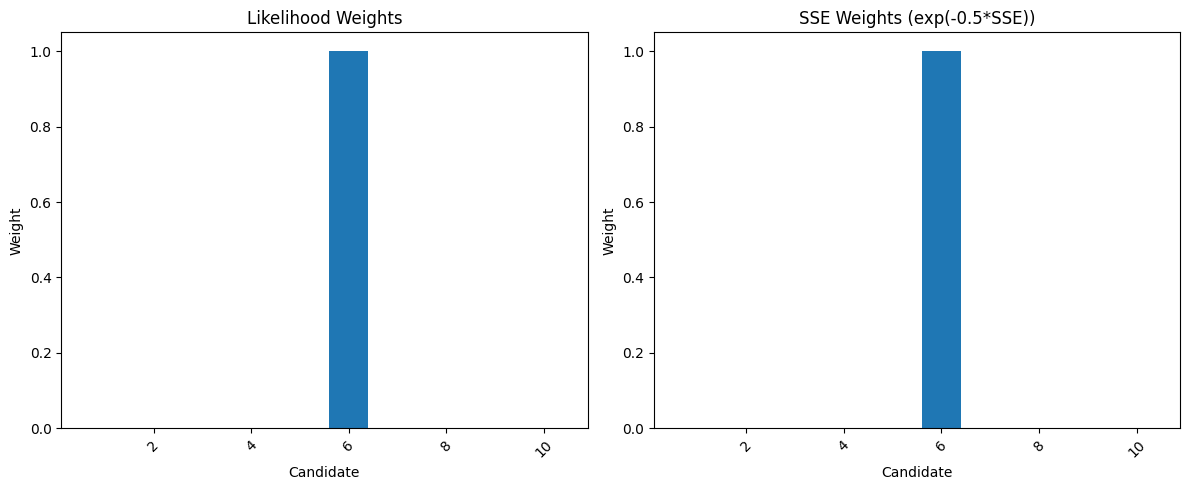


Correlation between Likelihood and SSE weights: 1.000


In [11]:
import matplotlib.pyplot as plt

# Display results
print("\n" + "="*80)
print("CANDIDATE EVALUATION RESULTS")
print("="*80)
print(f"{'#':<3} {'Node':<4} {'Var':<3} {'Threshold':<10} {'Likelihood':<12} {'SSE':<10} {'LH_Weight':<10} {'SSE_Weight':<10}")
print("-"*80)

for i in range(len(candidates)):
    cand = candidates[i]
    print(f"{i+1:<3} {cand['node_id']:<4} {cand['var']:<3} {cand['threshold']:<10.3f} "
          f"{likelihood_scores[i]:<12.3f} {sse_scores[i]:<10.3f} "
          f"{likelihood_weights[i]:<10.3f} {sse_weights[i]:<10.3f}")

# Find best candidates
best_lkhd_idx = np.argmax(likelihood_weights)
best_sse_idx = np.argmax(sse_weights)

print(f"\nBest by Likelihood: Candidate {best_lkhd_idx+1}")
print(f"Best by SSE: Candidate {best_sse_idx+1}")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Likelihood weights
ax1.bar(range(1, len(candidates)+1), likelihood_weights)
ax1.set_title('Likelihood Weights')
ax1.set_xlabel('Candidate')
ax1.set_ylabel('Weight')
ax1.tick_params(axis='x', rotation=45)

# SSE weights  
ax2.bar(range(1, len(candidates)+1), sse_weights)
ax2.set_title('SSE Weights (exp(-0.5*SSE))')
ax2.set_xlabel('Candidate')
ax2.set_ylabel('Weight')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate correlation between the two weight schemes
correlation = np.corrcoef(likelihood_weights, sse_weights)[0, 1]
print(f"\nCorrelation between Likelihood and SSE weights: {correlation:.3f}")